# Школа глубокого обучения

<a href="https://mipt.ru/science/labs/laboratoriya-neyronnykh-sistem-i-glubokogo-obucheniya/"><img align="right" src="https://avatars1.githubusercontent.com/u/29918795?v=4&s=200" alt="DeepHackLab" style="position:relative;top:-40px;right:10px;height:100px;" /></a>



### Физтех-Школа Прикладной математики и информатики МФТИ 
### Лаборатория нейронных сетей и глубокого обучения (DeepHackLab)

*Сергей Червонцев (ФИВТ МФТИ)*

## BasicRNN

В этом ноутбуке мы проверим качество BasicRNN на простом примере, а затем разберёмся, как писать RNN на Pytorch-е.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# для работы с датами
import datetime
import matplotlib.dates as dates

# для графиков
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

### Подготовка данных

Одно из главных применений RNN - работа со временными рядами.

Давайте возьмём датасет ежеминутного курса биткоина к доллару и сформулируем задачу так:
нам даны цены за двадцать последовательных дней, а мы предсказываем цену в двадцать первый. В качестве лосса и метрики качества будем использовать среднюю абсолютную ошибку (L1Loss).

Сперва обработаем данные...(**этот этап можно пропустить**)

In [2]:
def load_trade_data(period='D', debug=True):
    # используем датасет отсюда: https://www.kaggle.com/mczielinski/bitcoin-historical-data/data
    
    raw_df = pd.read_csv('data/coinbaseUSD_1-min_data_2014-12-01_to_2018-01-08.csv')
    raw_df['Datetime'] = pd.to_datetime(raw_df['Timestamp'],unit='s')
    
    # удаляем старые данные
    raw_df = raw_df[raw_df['Datetime'].dt.date > datetime.date(2017, 2, 1)]
    
    raw_df = raw_df.drop(['Timestamp'], axis=1)
    # группируем за нужный период (по дням, по дням и часам, etc)
    raw_df['Periodic Datetime'] = raw_df['Datetime'].dt.to_period(period)
    
    if debug:
        print(raw_df.head())
    
    group = raw_df.groupby([raw_df['Periodic Datetime']], as_index=False).mean()
    trade_data = group['Weighted_Price']
    trade_data.index = group['Periodic Datetime']
    trade_data.index = trade_data.index.to_timestamp()
    
    return trade_data

In [3]:
day_trade_data = load_trade_data(period='D')

           Open    High     Low   Close  Volume_(BTC)  Volume_(Currency)  \
1084673  992.75  992.95  992.75  992.94      1.338920        1329.464360   
1084674  992.97  993.00  992.95  993.00      5.730207        5689.902194   
1084675  993.00  993.15  992.97  993.15      4.540500        4509.026923   
1084676  993.14  993.50  993.11  993.50      7.497642        7447.330173   
1084677  993.49  993.72  993.49  993.72      7.113575        7068.009754   

         Weighted_Price            Datetime Periodic Datetime  
1084673      992.938112 2017-02-02 00:00:00        2017-02-02  
1084674      992.966218 2017-02-02 00:01:00        2017-02-02  
1084675      993.068368 2017-02-02 00:02:00        2017-02-02  
1084676      993.289588 2017-02-02 00:03:00        2017-02-02  
1084677      993.594590 2017-02-02 00:04:00        2017-02-02  


In [4]:
day_trade_data.describe()

count      341.000000
mean      4533.634433
std       4362.483607
min        929.751373
25%       1340.316496
50%       2741.336429
75%       5615.908305
max      19537.276941
Name: Weighted_Price, dtype: float64

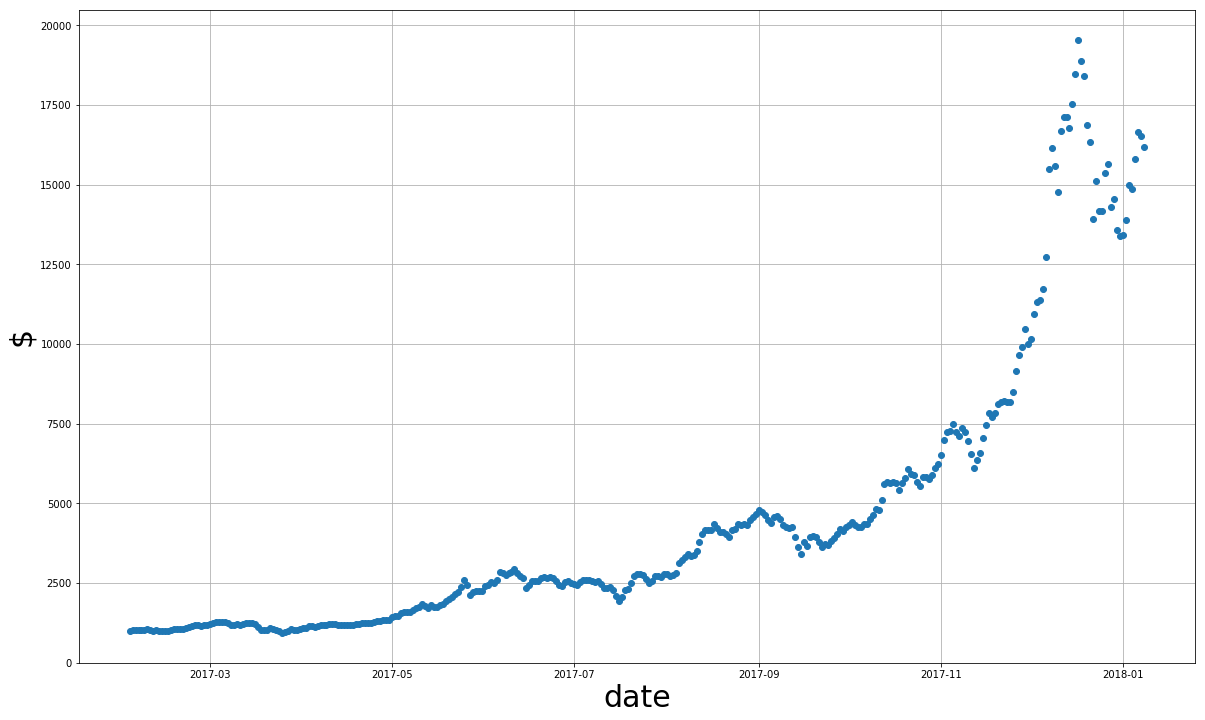

In [5]:
# Динамика курса биткоина по датам
plt_dates = dates.date2num(day_trade_data.index.to_pydatetime())
plt.figure(figsize=(20, 12))
plt.plot_date(plt_dates, day_trade_data.values)
plt.xlabel('date', fontsize=30)
plt.ylabel('$', fontsize=30)
plt.grid()
plt.show()

In [6]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(-3,3))

normalized_trade_data = sc.fit_transform(day_trade_data.values.reshape(-1,1)).reshape(-1)

train_len = 30
prediction_days = 20

X_full, y_full = [], []

for i in range(0, len(normalized_trade_data)-train_len):
    X_full += [normalized_trade_data[i:i+train_len]]
    y_full += [day_trade_data[i+train_len]]

X_train, X_test = np.array(X_full[:-prediction_days]), np.array(X_full[-prediction_days:])
y_train, y_test = np.array(y_full[:-prediction_days]), np.array(y_full[-prediction_days:])

In [7]:
X_train.shape, X_test.shape

((291, 30), (20, 30))

In [8]:
pd.Series(normalized_trade_data).describe()

count    341.000000
mean      -1.837927
std        1.406684
min       -3.000000
25%       -2.867613
50%       -2.415854
75%       -1.488948
max        3.000000
dtype: float64

In [9]:
from sklearn.metrics import mean_absolute_error as MAE

def get_error(logits, y_true):
    return MAE(sc.inverse_transform(logits.reshape(-1,1)).reshape(-1), y_true)

def get_prediction(logits):
    return sc.inverse_transform(logits.reshape(-1,1)).reshape(-1)

In [10]:
get_error(X_train.mean(1), y_train), get_error(X_train[:,-1], y_train)

(836.7910111299602, 144.67614763231356)

### Numpy код

Теперь напишем простейшую RNN на чистом numpy. Вместо градиентного спуска мы просто переберём возможные параметры по сетки (у нас их два), а заодно построим трёхмерный график получившейся ошибки.

In [11]:
def batch_wise_dummy_RNN(X, W_hx, W_hh, b_h=0):
    # простая BasicRNN
    # обозначения те же, что в лекциях
    # sigma_h(t) = 3*tanh(t), sigma_o(t) = t
    batch_size = X.shape[0]
    sequence_len = X.shape[1]
    
    h = np.zeros((batch_size, sequence_len+1))
    o = np.zeros((batch_size, sequence_len+1))
    
    for t in range(0, sequence_len):
        h[:, t + 1] = 3 * np.tanh(W_hx * X[:, t] + W_hh * h[:, t] + b_h * np.ones((batch_size,)))
        o[:, t + 1] = h[:, t + 1]

    return o[:, -1]

In [12]:
from tqdm import tqdm

# строим сетку, по которой будем перебирать
W_hx_set = np.linspace(-1,1,100)
W_hh_set = np.linspace(-1,1,100)
A, B = np.meshgrid(W_hx_set, W_hh_set)

losses = []
for W_hx, W_hh in tqdm(zip(np.ravel(A), np.ravel(B))):
    new_pred = batch_wise_dummy_RNN(X_train, W_hx, W_hh)
    losses += [get_error(new_pred, y_train)]

losses = np.array(losses)

10000it [00:10, 945.74it/s]


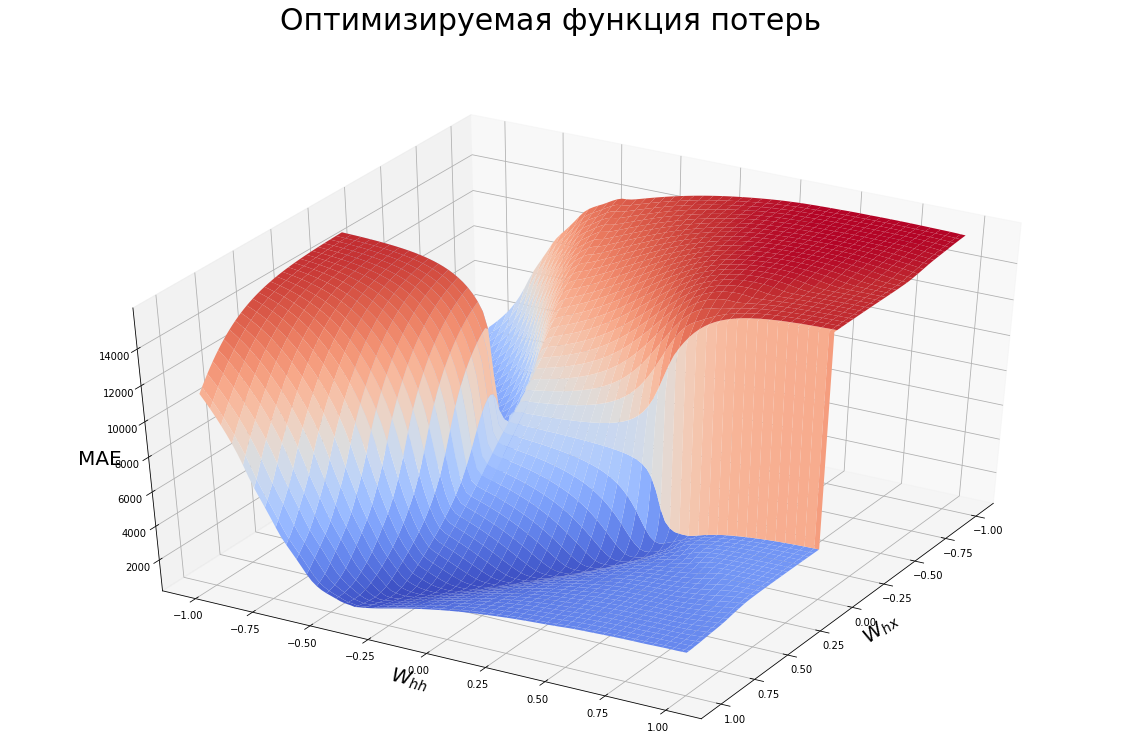

In [13]:
# трёхмерный график функции потерь
fig = plt.figure(figsize=(20,12))
fig.suptitle('Оптимизируемая функция потерь', fontsize=30)
ax = fig.add_subplot(111, projection='3d')

Z = losses.reshape(A.shape)

ax.plot_surface(A, B, Z, cmap=cm.coolwarm)
ax.set_xlabel('$W_{hx}$',fontsize=20)
ax.set_ylabel('$W_{hh}$', fontsize=20)
ax.set_zlabel('MAE', fontsize=20)
ax.view_init(40, 30)
plt.show()

In [14]:
opt_inxs = np.where(Z == np.min(Z))

W_hx_optim, W_hh_optim = W_hx_set[opt_inxs[1][0]], W_hh_set[opt_inxs[0][0]]

print('Optimal params:', W_hx_optim, W_hh_optim)

optim_logit_train = batch_wise_dummy_RNN(X_train, W_hx_optim, W_hh_optim, 2e-5)
optim_logit_test = batch_wise_dummy_RNN(X_test, W_hx_optim, W_hh_optim, 2e-5)
tr_error, te_error = get_error(optim_logit_train, y_train), get_error(optim_logit_test, y_test)

print('Optimal scores:', tr_error, te_error)

Optimal params: 0.7777777777777779 -0.31313131313131304
Optimal scores: 459.83931387241876 1195.8568271625813


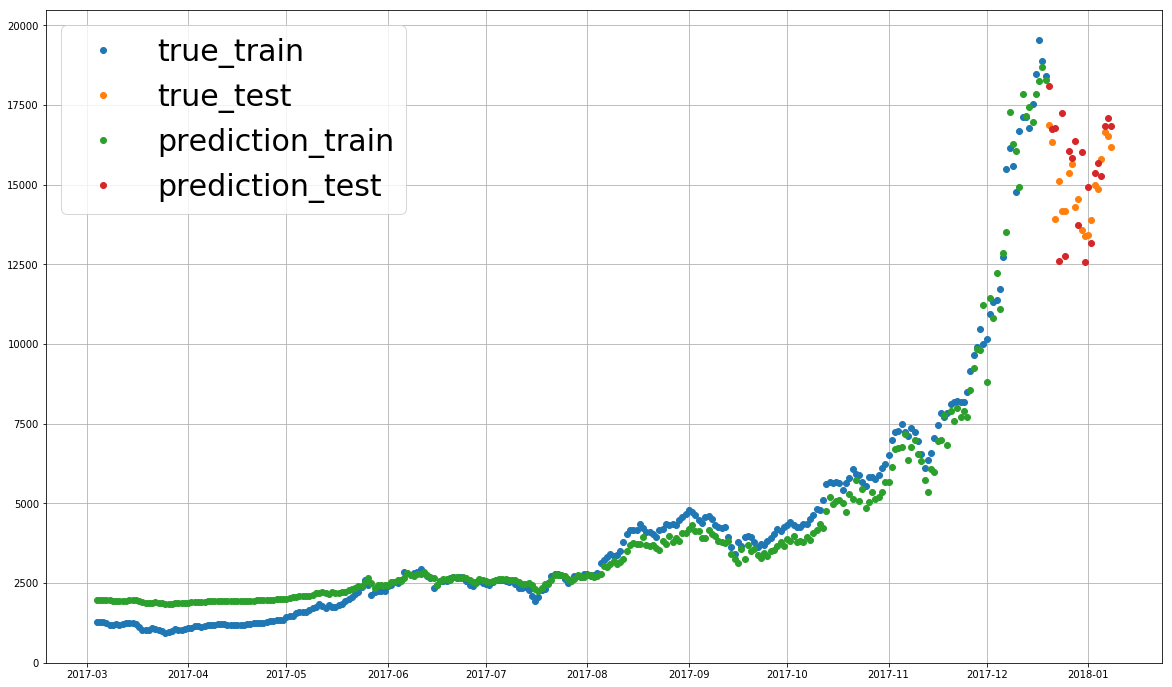

In [15]:
plt.figure(figsize=(20, 12))
#plt.title('BTC - $', fontsize=40)
train_dates = plt_dates[train_len:-prediction_days]
test_dates = plt_dates[-prediction_days:]

plt.plot_date(train_dates, y_train, label='true_train')
plt.plot_date(test_dates, y_test, label='true_test')

plt.plot_date(train_dates, get_prediction(optim_logit_train), label='prediction_train')
plt.plot_date(test_dates, get_prediction(optim_logit_test), label='prediction_test')

plt.grid()
plt.legend(loc='best', fontsize=30)
plt.show()

### Подготовка данных

Теперь напишем такую же модель на PyTorch.

In [16]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

In [17]:
X_full, y_full = [], []
for i in range(0, len(day_trade_data)-train_len):
    X_full += [normalized_trade_data[i:i+train_len]]
    y_full += [normalized_trade_data[i+train_len]]

X_train, X_test = np.array(X_full[:-prediction_days]), np.array(X_full[-prediction_days:])
y_train, y_test = np.array(y_full[:-prediction_days]), np.array(y_full[-prediction_days:])

In [18]:
def sample_batch(X, y, batch_size=30, offset=None):
    # генерация обучающих выборок
    if offset is None:
        ixs = np.random.randint(0, X.shape[0], size=(batch_size,))
    else:
        ixs = range(offset, min(offset + batch_size, X.shape[0]))
    return np.expand_dims(X[ixs,:], axis=2), y[ixs]

In [19]:
def test_score(X, y, model, batch_size):
    # тестирование модели (сферической в вакууме)
    total_metrics = 0
    n_batches = int(len(X) / batch_size) + 1
    
    for offset in range(0, len(X), batch_size):
        # Генерируем батч
        inputs, targets = sample_batch(X, y, batch_size, offset)
        inputs = Variable(torch.FloatTensor(inputs))
        targets = Variable(torch.FloatTensor(targets))
        
        # Делаем forward pass
        output = model(inputs)
        
        total_metrics += get_error(output.data.numpy(),
                                 sc.inverse_transform(targets.data.numpy().reshape(-1,1)).reshape(-1))
        
    return total_metrics / n_batches

In [20]:
def train(X, y, model, criterion, epochs=1, batch_size=30, debug=True):
    # обучение модели (опять же какой-то)
    model.train()
    
    n_batches = int(len(X) / batch_size)
    all_losses = []
    all_metrics = []
    
    for epoch in range(epochs):
        total_loss = 0
        
        if debug:
            print('-'*20)
            print('EPOCH:', epoch)
        
        for batch in range(n_batches):
            # Генерируем батч
            inputs, targets = sample_batch(X, y, batch_size)
            inputs = Variable(torch.FloatTensor(inputs))
            targets = Variable(torch.FloatTensor(targets))
            
            # Зануляем градиенты
            model.zero_grad()
            
            # Делаем forward pass
            output = model(inputs)
            
            # Считаем loss и делаем backprop
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            
            # Собираем ошибки
            total_loss += loss.data[0]
            all_losses += [loss.data[0]]
        
        all_metrics += [test_score(X, y, model, 10)]
            
        if debug:
            print('TRAIN LOSS:', total_loss / n_batches)
            print('TRAIN METRICS (MAE, e.g.):', all_metrics[-1])
    return all_losses, all_metrics

In [21]:
class SequenceRNNBase(nn.Module):
    # Простая RNN
    def __init__(self, input_size, hidden_size, output_size=1, activation=None):
        super(SequenceRNNBase, self).__init__()
        
        self.hidden_size = hidden_size
        # W_{hx}, W_{hh}, b_{h}
        self.input2hidden = nn.Linear(input_size + hidden_size, hidden_size)
        # W_{oh}, b_{oh}
        self.hidden2output = nn.Linear(hidden_size, output_size)
        # sigma_h
        self.activation = activation
    
    def forward(self, inputs):
        seq_len = inputs.shape[1]
        hidden = self.init_hidden(inputs.shape[0])
        
        for step in range(seq_len):
            # step = t, inputs[:,step] = X_t (несколько параллельно)
            combined = torch.cat((inputs[:,step], hidden), dim=1)
            if self.activation is None:
                # hidden = h_t
                hidden = self.input2hidden(combined)
            else:
                hidden = self.activation(self.input2hidden(combined))
        
        return self.hidden2output(hidden)
    
    def init_hidden(self, batch_size):
        return Variable(torch.zeros((batch_size, self.hidden_size)))

In [22]:
LR = 1e-2

rnn_base = SequenceRNNBase(1, 1, activation=lambda X: 3*F.tanh(X))

optimizer = optim.Adam(rnn_base.parameters(), lr=LR)
loss_function = nn.L1Loss()

In [23]:
# учим модель
losses_hist, metrics_hist = train(X_train, y_train, rnn_base, loss_function, 
                                  epochs=20, batch_size=32)

--------------------
EPOCH: 0
TRAIN LOSS: 1.97250231107076
TRAIN METRICS (MAE, e.g.): 5697.995198567708
--------------------
EPOCH: 1
TRAIN LOSS: 1.6040878958172269
TRAIN METRICS (MAE, e.g.): 4823.10307413737
--------------------
EPOCH: 2
TRAIN LOSS: 1.375260180897183
TRAIN METRICS (MAE, e.g.): 4169.737095133463
--------------------
EPOCH: 3
TRAIN LOSS: 1.2001457280582852
TRAIN METRICS (MAE, e.g.): 3300.322669474284
--------------------
EPOCH: 4
TRAIN LOSS: 0.9515935182571411
TRAIN METRICS (MAE, e.g.): 2567.720396931966
--------------------
EPOCH: 5
TRAIN LOSS: 0.6890591581662496
TRAIN METRICS (MAE, e.g.): 2091.280771891276
--------------------
EPOCH: 6
TRAIN LOSS: 0.5699489182896085
TRAIN METRICS (MAE, e.g.): 1811.5274576822917
--------------------
EPOCH: 7
TRAIN LOSS: 0.43375592099295723
TRAIN METRICS (MAE, e.g.): 1438.802023824056
--------------------
EPOCH: 8
TRAIN LOSS: 0.3750083910094367
TRAIN METRICS (MAE, e.g.): 1142.7993629455566
--------------------
EPOCH: 9
TRAIN LOSS: 0.272

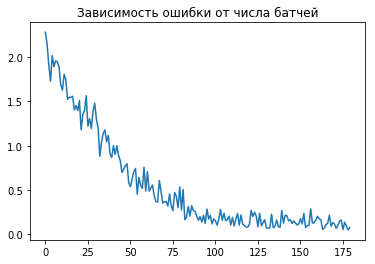

In [24]:
plt.title(u'Зависимость ошибки от числа батчей')
plt.plot(losses_hist)
plt.show()

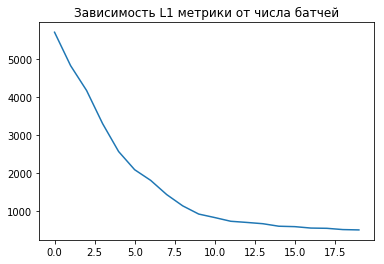

In [25]:
plt.title(u'Зависимость L1 метрики от числа батчей')
plt.plot(metrics_hist)
plt.show()

In [26]:
# качество на тесте
test_score(X_test, y_test, rnn_base, 10)

1562.7483723958333